<a href="https://colab.research.google.com/github/anh56/CoderSchool/blob/master/4_Exercise_NaiveBayes_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bài tập Naive Bayes

## Sử dụng GaussianNB để phân nhóm cho tập Titanic dataset
- dataset: 'Titanic_train.csv', 'Titanic_test.csv'


In [115]:
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.55 s


In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,auc,roc_auc_score
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score

time: 3.33 ms


In [117]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 4.5 ms


In [118]:
train = pd.read_csv('/content/drive/My Drive/AI_LAB/4-naive bayes/Titanic_train.csv')
test = pd.read_csv('/content/drive/My Drive/AI_LAB/4-naive bayes/Titanic_test.csv')

time: 17.2 ms


In [119]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


time: 26.8 ms


In [120]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
time: 13.6 ms


In [121]:
train.describe(include=['object', 'bool'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Willey, Mr. Edward",male,1601,B96 B98,S
freq,1,577,7,4,644


time: 37.3 ms


In [122]:
train['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

time: 7.16 ms


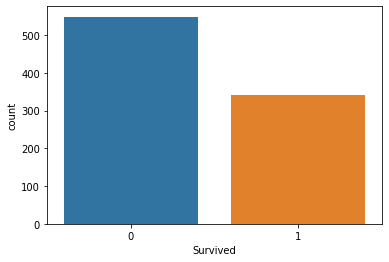

time: 129 ms


In [123]:
sns.countplot(train['Survived'])

In [124]:
full_data = [train, test]

time: 2.27 ms


In [125]:
pd.isnull(train).any() | pd.isnull(test).any()

Age             True
Cabin           True
Embarked        True
Fare            True
Name           False
Parch          False
PassengerId    False
Pclass         False
Sex            False
SibSp          False
Survived       False
Ticket         False
dtype: bool

time: 12.3 ms


In [126]:
# Fill "S" for null values in  the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Fill values for  NULLS in the Fare column
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

time: 7.45 ms


In [127]:
#missing data for "Age"
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    # Next line has been improved to avoid warning
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

time: 14.6 ms


In [128]:
pd.isnull(train).any() | pd.isnull(test).any()

Age            False
Cabin           True
Embarked       False
Fare           False
Name           False
Parch          False
PassengerId    False
Pclass         False
Sex            False
SibSp          False
Survived       False
Ticket         False
dtype: bool

time: 10.6 ms


In [129]:
import re
# Add values for NULLS in the Age column
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    # Next line has been improved to avoid warning
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] ;

time: 98.1 ms


In [130]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,1,1,0,A/5 21171,0,NaN,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,PC 17599,3,C85,1,3
2,3,1,3,"Heikkinen, Miss. Laina",0,1,0,0,STON/O2. 3101282,1,NaN,0,4
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,2,1,0,113803,3,C123,0,3
4,5,0,3,"Allen, Mr. William Henry",1,2,0,0,373450,1,NaN,0,1


time: 29.4 ms


In [131]:
# Feature selection: remove variables no longer containing relevant information
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

time: 4.85 ms


In [132]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Title
0,0,3,1,1,0,0,0,1
1,1,1,0,2,0,3,1,3
2,1,3,0,1,0,1,0,4
3,1,1,0,2,0,3,0,3
4,0,3,1,2,0,1,0,1


time: 29.7 ms


####For train set, we will see what Bayes works best

In [133]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

time: 3.05 ms


In [134]:
X = train.drop('Survived', axis = 1)
y = train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 50)
print(X_train.shape, y_train.size)
print(X_test.shape, y_test.shape)

(712, 7) 712
(179, 7) (179,)
time: 10.2 ms


In [135]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

time: 1.6 ms


In [136]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_predict_train_gnb = gnb.predict(X_test)
y_predict_train_gnb

array([1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1])

time: 11.1 ms


In [137]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
y_predict_train_bnb = bnb.predict(X_test)
y_predict_train_bnb

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1])

time: 10.4 ms


In [138]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_predict_train_mnb = mnb.predict(X_test)
y_predict_train_mnb

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1])

time: 12.6 ms


In [139]:
print(f"GaussianNB classifier accuracy score for test set is {gnb.score(X_test, y_test)}")
print(f"Bernoulli classifier accuracy score for test set is {bnb.score(X_test, y_test)}")
print(f"MultinomialNB classifier accuracy score for test set is { mnb.score(X_test, y_test)}")

GaussianNB classifier accuracy score for test set is 0.7988826815642458
Bernoulli classifier accuracy score for test set is 0.770949720670391
MultinomialNB classifier accuracy score for test set is 0.7653631284916201
time: 13.9 ms


In [140]:
print('GNB test-set confusion matrix:\n', confusion_matrix(y_test,y_predict_train_gnb)) 
print('BNB test-set confusion matrix:\n', confusion_matrix(y_test,y_predict_train_bnb)) 
print('MNB test-set confusion matrix:\n', confusion_matrix(y_test,y_predict_train_mnb)) 

GNB test-set confusion matrix:
 [[84 17]
 [19 59]]
BNB test-set confusion matrix:
 [[88 13]
 [28 50]]
MNB test-set confusion matrix:
 [[80 21]
 [21 57]]
time: 9.56 ms


In [141]:
print(classification_report(y_test, y_predict_train_gnb))
print(classification_report(y_test, y_predict_train_bnb))
print(classification_report(y_test, y_predict_train_mnb))

              precision    recall  f1-score   support

           0       0.82      0.83      0.82       101
           1       0.78      0.76      0.77        78

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179

              precision    recall  f1-score   support

           0       0.76      0.87      0.81       101
           1       0.79      0.64      0.71        78

    accuracy                           0.77       179
   macro avg       0.78      0.76      0.76       179
weighted avg       0.77      0.77      0.77       179

              precision    recall  f1-score   support

           0       0.79      0.79      0.79       101
           1       0.73      0.73      0.73        78

    accuracy                           0.77       179
   macro avg       0.76      0.76      0.76       179
weighted avg       0.77      0.77      0.77       179

time: 18.9 ms


In [142]:
print(f"GaussianNB classifier cross_val_score for test set is {np.mean(cross_val_score(gnb, X_test, y_test, cv = 10))}")
print(f"Bernoulli classifier cross_val_score score for test set is {np.mean(cross_val_score(bnb, X_test, y_test, cv = 10))}")
print(f"MultinomialNB classifier cross_val_score for test set is { np.mean(cross_val_score(mnb, X_test, y_test, cv = 10))}")

GaussianNB classifier cross_val_score for test set is 0.7820261437908497
Bernoulli classifier cross_val_score score for test set is 0.7372549019607844
MultinomialNB classifier cross_val_score for test set is 0.7598039215686275
time: 113 ms


Looks like GaussianNB is the best for this case, we will use this to predict for the Titanic-test.csv

In [143]:
y_predict_gnb = gnb.predict(test)
y_predict_gnb

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

time: 5.67 ms


In [144]:
score_gnb = cross_val_score(gnb, test, y_predict_gnb, cv = 10)
print(f"GaussianNB classifier cross_val_score for test set is {score_gnb}")
print(f"Avg is {np.mean(score_gnb)}")

GaussianNB classifier cross_val_score for test set is [0.92857143 1.         0.95238095 1.         0.9047619  0.97619048
 0.9047619  0.95238095 0.92682927 0.97560976]
Avg is 0.9521486643437864
time: 36.3 ms


Really high accuracy, but let's just test for the other 2 for demonstration purposes

In [145]:
y_predict_bnb = bnb.predict(test)
y_predict_mnb = mnb.predict(test)
score_bnb = cross_val_score(bnb, test, y_predict_bnb, cv = 10)
score_mnb = cross_val_score(mnb, test, y_predict_mnb, cv = 10)
print(f"Bernoulli classifier cross_val_score score for test set is {score_bnb}")
print(f"Avg is {np.mean(score_bnb)}")

print(f"MultinomialNB classifier cross_val_score for test set is { score_mnb }")
print(f"Avg is {np.mean(score_mnb)}")

Bernoulli classifier cross_val_score score for test set is [0.97619048 0.95238095 0.95238095 0.97619048 0.92857143 1.
 1.         1.         1.         0.97560976]
Avg is 0.9761324041811846
MultinomialNB classifier cross_val_score for test set is [0.92857143 0.97619048 0.97619048 0.95238095 0.92857143 0.97619048
 1.         0.97619048 0.97560976 0.97560976]
Avg is 0.9665505226480835
time: 68.3 ms
